In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import statsmodels.formula.api as smf
import os

class PanelVAR:
    def __init__(self, data: pd.DataFrame, idx_col: str, time_col: str, horizon: int):
        """
        Initialize the PanelVAR class.

        Parameters:
        - data (pd.DataFrame): The panel dataset.
        - idx_col (str): The column name representing countries.
        - time_col (str): The column name representing time periods.
        """
        self.data = data
        self.idx_col = idx_col
        self.time_col = time_col
        self.horizon = horizon

    def demean_within_idx(self, data, variables: list):
        """
        Demean specified variables across periods within each idx.

        Parameters:
        - data: pandas dataframe
        - variables (list): List of variable names to demean.

        Returns:
        - pd.DataFrame: A DataFrame with demeaned variables.
        """
        demeaned_data = data.copy().dropna()
        demeaned_data[variables] = demeaned_data.groupby(self.idx_col)[variables].transform(
            lambda x: x - x.mean()
        )
        
        return demeaned_data[[self.idx_col, self.time_col] + variables]

    def estimate_structural_var(self, variables: list, lags: int, data=None):
        """
        Estimate a structural VAR for specified variables using Cholesky identification.

        Parameters:
        - variables (list): List of variable names to include in the VAR.
        - lags (int): Number of lags to include in the VAR model.
        - data: pandas dataframe, if not included, use base data (self.data)

        Returns:
        - results (dict): for each idx, returns the fitted_model, a cholesky-decomposed
            lower triangular matrix P, the reduced form and structural variance covariance
            matrices, and a dataframe of reduced-form and structural residuals
        """
        if data is None:
            data = self.data
        
        results = {}
        
        demeaned_data = self.demean_within_idx(data, variables)
        
        for idx, group_data in demeaned_data.groupby(self.idx_col):
            group_data = group_data.sort_values(self.time_col)
            model = VAR(group_data[variables])
            fitted_model = model.fit(lags)

            # Perform Cholesky decomposition, transform reduced form residuals into structural
            cholesky = np.linalg.cholesky(fitted_model.sigma_u)
            u = fitted_model.resid.T
            eps = np.matmul(np.linalg.inv(cholesky), u)            # recall, since eps = P^{-1} u
            varcov_eps = np.matmul( eps, eps.T )
            resid = group_data[[self.idx_col, self.time_col]]
            
            i = 0
            for var in variables:
                resid.loc[:,var + '_u'] = u.iloc[i,:]
                resid.loc[:,var + '_eps'] = eps.iloc[i,:]
                i += 1
    
            results[idx] = {
                'fitted_model': fitted_model,
                'P': cholesky,
                'varcov_u': fitted_model.sigma_u,
                'varcov_eps': varcov_eps,
                'resid': resid
            }

        return results

    def compute_impulse_responses(self, variables: list, lags: int, data=None, normalize=True):
        """
        Compute impulse response functions (IRFs) for all countries up to a specified horizon.

        Parameters:
        - variables (list): List of variable names to include in the VAR.
        - lags (int): Number of lags to include in the VAR model.
        - data: pandas dataframe, if not included, use base data (self.data)

        Returns:
        - mat_col: matrix with IRF responses for each panel member
        """        
        if data is None:
            data = self.data

        var_results = self.estimate_structural_var(variables, lags, data)

        n = len(variables)
        idxn = len(var_results.keys())

        mat_col = np.zeros([n,n,self.horizon,idxn])
        
        idxx = 0
        for idx, result in var_results.items():
            fitted_model = result['fitted_model']

            # Compute IRFs            
            irf = fitted_model.irf(self.horizon)
            irf_matrix = irf.orth_irfs
                    
            for i in range(len(variables)):
                resp_mat = irf_matrix[:,i]
                for j in range(len(variables)):
                    for h in range(self.horizon):
                        mat_col[i,j,h,idxx] = resp_mat[h,j]
                        
                if normalize == True:
                    mat_col[:,i,:,idxx] = mat_col[:,i,:,idxx] / mat_col[i,i,0,idxx]

            idxx += 1

        return mat_col
    
    def collect_moments(self, mat_col: np.array, pctiles = [25,75], pcttiles_method = 'closest_observation'):
        """
        Compute moments for the distributions of IRFs

        Parameters:
        - mat_col (array): matrix with IRF responses for each panel member
        - pctiles (list): percentiles to be calculated
        - pcttiles_method (str): optional parameter that chooses the method of computation of percentiles (e.g., linear)

        Returns:
        - median_mat (array): median responses of of variable j to shocks in variable i at each horizon h
        - average_mat (array): average responses of of variable j to shocks in variable i at each horizon h
        - moments_mat (array): ercentiles of responses of of variable j to shocks in variable i at each horizon h
        - pctiles (list): same as input
        """
        
        shape = mat_col.shape
        n = shape[0]
        moments = len(pctiles)
        
        moments_mat = np.zeros([n,n,self.horizon,moments])
        median_mat = np.zeros([n,n,self.horizon])
        average_mat = np.zeros([n,n,self.horizon])
                
        for i in range(n):
            for j in range(n):
                for h in range(self.horizon):
                    vec = mat_col[i,j,h,:]                    
                    moments_mat[i,j,h,:] = np.percentile(vec, pctiles, method=pcttiles_method)
                    median_mat[i,j,h] = np.percentile(vec, 50, method=pcttiles_method)
                    average_mat[i,j,h] = np.mean(vec)
        
        return moments_mat, median_mat, average_mat, pctiles
    
    def plot_moments(self, variables: list, moments_mat: np.array, median_mat: np.array, average_mat: np.array, pctiles: list, figsize=(10,10), titles_dict = {}):
        """
        Plots IRF charts with median, average, and percentile responses

        Parameters:
        - median_mat (array): median responses of of variable j to shocks in variable i at each horizon h
        - average_mat (array): average responses of of variable j to shocks in variable i at each horizon h
        - moments_mat (array): ercentiles of responses of of variable j to shocks in variable i at each horizon h
        - pctiles (list): same as input
        - titles_dict (dict): optional input to relabel variables in plots

        Returns:
        - fig: a figure with n by n subplots of response functions
        """
        
        n, moments = moments_mat.shape[0], moments_mat.shape[3]
        
        if titles_dict == {}:
            titles = variables
        else:
            titles = [titles_dict[x] for x in variables]
        
        fig, ax = plt.subplots(nrows=n,ncols=n, figsize=figsize)
        
        for i in range(n):
            for j in range(n):
                ax[i,j].plot(median_mat[i,j,:], 'o-', label="Median", color='red')
                ax[i,j].plot(average_mat[i,j,:], '*-', label="Average", color='navy')
                ax[i,j].axhline(y=0, color='black')
                ax[i,j].set_title(f"Shock: {titles[j]}. Response: {titles[i]}.")
                ax[i,j].grid(True)
                for m in range(moments):
                    ax[i,j].plot(moments_mat[i,j,:], ':', color='grey')
                    
        
        # Add labels, legend, and title
        plt.legend()
        
        # Show the plot
        plt.show()
        
        return fig


    def estimate_structural_var_on_averages(self, variables: list, lags: int):
        """
        Estimate a panel VAR on idx-averaged variables and perform Cholesky decomposition.

        Parameters:
        - variables (list): List of variable names to include in the VAR.
        - lags (int): Number of lags to include in the VAR model.

        Returns:
        - dict: A dictionary containing the fitted VAR model and Cholesky decomposition matrix.
        """
        # Calculate averages across all countries for each period
        averaged_data = self.data.groupby(self.time_col)[variables].mean().dropna().reset_index()

        # Estimate VAR on the averaged data
        model = VAR(averaged_data[variables])
        fitted_model = model.fit(lags)

        # Perform Cholesky decomposition, transform reduced form residuals into structural
        cholesky = np.linalg.cholesky(fitted_model.sigma_u)
        u = fitted_model.resid.T
        eps = np.matmul(cholesky, u)
        varcov_eps = np.matmul( eps, eps.T )
        resid = averaged_data[[self.time_col]]
            
        i = 0
        for var in variables:
            resid.loc[:,var + '_u'] = u.iloc[i,:]
            resid.loc[:,var + '_eps'] = eps.iloc[i,:]
            i += 1
    
        return {
                'fitted_model': fitted_model,
                'P': cholesky,
                'varcov_u': fitted_model.sigma_u,
                'varcov_eps': varcov_eps,
                'resid': resid
            }

    
    def extract_factor_loadings(self, variables, lags):
        """
        Extracts factor loadings from structural residuals.

        Parameters:
        - variables (list): List of variable names to include in the VAR.
        - lags (int): Number of lags to include in the VAR model.

        Returns:
        - factors (dict): for each idx, stores a n-by-n matrix of factor loadings
        """
        
        n = len(variables)
        
        var_results = self.estimate_structural_var(variables, lags)       
        avg_results = self.estimate_structural_var_on_averages(variables, lags)
        
        avg_resid = avg_results['resid']
        factors = {}
        for idx in var_results.keys():
            idx_resid = var_results[idx]['resid']
            resid_frame = pd.merge(avg_resid, idx_resid, how='left', on=self.time_col, suffixes=['_avg',''])
            
            lambda_i = np.zeros([n,n])
            m = 0
            for var in variables:
                params = smf.ols(f'{var}_eps ~ {var}_eps_avg', data=resid_frame).fit().params
                lambda_i[m,m] = params[f'{var}_eps_avg']
                m += 1
            factors.update({idx: lambda_i})
        
        return factors
                
                
    def decompose_irfs(self, variables, lags, pcttiles_method='closest_observation'):

        """
        Decomposes median IRFs between common and idiosyncratic factors
        
        This uses 

        Parameters:
        - variables (list): List of variable names to include in the VAR.
        - lags (int): Number of lags to include in the VAR model.

        Returns:
        - median_common (array): common components of median responses
        - median_id (array): idiosyncratic component of median responses components of median responses
        """

    
        mat_col = self.compute_impulse_responses(variables, lags)
        factors = self.extract_factor_loadings(variables, lags)
        
        n = mat_col.shape[0]
                
        mat_common = mat_col * 0
        mat_id = mat_col * 0    
        
        idxx = 0
        for idx in factors.keys():
            for h in range(self.horizon):
                mat_common[:,:,h,idxx] = np.matmul( mat_col[:,:,h,idxx] , factors[idx] ) 
                mat_id[:,:,h,idxx] = (np.eye(n) - np.matmul(factors[idx],factors[idx].T))**(-1/2) * (mat_col[:,:,h,idxx] - mat_common[:,:,h,idxx])
            idxx += 1
        
        # extract averages
        n = mat_common.shape[0]
        median_common = np.zeros([n,n,self.horizon])
        median_id = np.zeros([n,n,self.horizon])
        median_tot = np.zeros([n,n,self.horizon])
                
        for i in range(n):
            for j in range(n):
                for h in range(self.horizon):
                    v1, v2 = mat_common[i,j,h,:], mat_col[i,j,h,:]
                    median_common[i,j,h] = np.percentile(v1, 50, method=pcttiles_method) 
                    median_tot[i,j,h] = np.percentile(v2, 50, method=pcttiles_method)
                    median_id[i,j,h] = median_tot[i,j,h]  - median_common[i,j,h]
        
        return median_common, median_id
    
    def plot_decomposed_irfs(self, median_common, median_id, figsize=(10,10), titles_dict={}):
        
        r = range(self.horizon)
        n = median_common.shape[0]
        
        if titles_dict == {}:
            titles = variables
        else:
            titles = [titles_dict[x] for x in variables]
        
        fig, ax = plt.subplots(nrows=n,ncols=n, figsize=figsize)
        
        for i in range(n):
            for j in range(n):
                ax[i,j].plot(median_id[i,j,:], color='grey', label='Idiosyncratic')
                ax[i,j].plot(median_common[i,j,:], color='black', label='Common')
                ax[i,j].axhline(y=0, color='black')
                ax[i,j].set_title(f"Shock: {titles[j]}. Response: {titles[i]}.")
                ax[i,j].grid(True)                    
        
        # Add labels, legend, and title
        plt.legend()
        
        # Show the plot
        plt.show()
        
        return fig
    
    def calculate_se(self, variables, lags, draws=1000):

        var_results = self.estimate_structural_var(variables, lags)       
        avg_results = self.estimate_structural_var_on_averages(variables, lags)
        factors = self.extract_factor_loadings(variables, lags)
        base_data = self.data
        n = len(variables)

        avg_resid = avg_results['resid']
        median_mat_draws = np.zeros([n,n,self.horizon,draws])
        average_mat_draws = np.zeros([n,n,self.horizon,draws])
        
        for draw in range(draws):
            dfs = []
            for idx, group_data in base_data.groupby(self.idx_col):
                try:
                    idx_resid = var_results[idx]['resid']
                except:
                    continue
                resid_frame = pd.merge(avg_resid, idx_resid, how='inner', on=self.time_col, suffixes=['_avg',''])
                
                # reshuffle structural residuals, keeping time structural component intact
                
                eps = []
                i = 0            
                for var in variables:
                    resid_frame[f'{var}_eps_c'] = resid_frame[f'{var}_eps'] * factors[idx][i,i]
                    resid_frame[f'{var}_eps_id'] = resid_frame[f'{var}_eps'] - resid_frame[f'{var}_eps_c']
                    resid_frame.loc[lags:,f'{var}_eps_id_r'] = list(resid_frame[f'{var}_eps_id'].dropna().sample(frac=1).reset_index(drop=True))
                    resid_frame.loc[lags:,f'{var}_eps_c_r'] = list(resid_frame[f'{var}_eps_c'].dropna().sample(frac=1).reset_index(drop=True))
                    resid_frame[f'{var}_eps_r'] = resid_frame.loc[lags:,f'{var}_eps_id_r'] + resid_frame[f'{var}_eps_c_r']
                    eps.append( list(resid_frame[f'{var}_eps_r'].dropna()) )
                    i += 1
                    
                P = var_results[idx]['P']
                u = np.matmul(P, eps)
                
                fitted_frame = var_results[idx]['fitted_model'].fittedvalues
                out_frame = group_data.copy() 
                
                for i, var in enumerate(variables):
                    out_frame[f'{var}_r'] = u[i] + fitted_frame[f'{var}']
                
                dfs.append(out_frame)
                
            r_frame = pd.concat(dfs)
            r_vars = [x + '_r' for x in variables]               
            
            r_mat_col = self.compute_impulse_responses(r_vars, lags, data=r_frame)
            moments_mat, median_mat, average_mat, pctiles = self.collect_moments(r_mat_col)
            median_mat_draws[:,:,:,draw], average_mat_draws[:,:,:,draw] = median_mat, average_mat
        
        median_mat_se = np.zeros([n,n,self.horizon])
        average_mat_se = np.zeros([n,n,self.horizon])

        for i in range(n):
            for j in range(n):
                for h in range(self.horizon):
                    v1, v2 = median_mat_draws[i,j,h,:], average_mat_draws[i,j,h,:]
                    median_mat_se[i,j,h] = np.std(v1) 
                    average_mat_se[i,j,h] = np.std(v2)
        
        return median_mat_se, average_mat_se

   
    def plot_se(self, central_mat, central_mat_se, variables, figsize=(10,10), t_val=1.96, titles_dict = {}):

        n = central_mat_se.shape[0]
        
        if titles_dict == {}:
            titles = variables
        else:
            titles = [titles_dict[x] for x in variables]
        
        fig, ax = plt.subplots(nrows=n,ncols=n, figsize=figsize)
        
        for i in range(n):
            for j in range(n):
                ax[i,j].plot(central_mat[i,j,:], 'o-', label="Median", color='red')
                ax[i,j].axhline(y=0, color='black')
                ax[i,j].set_title(f"Shock: {titles[j]}. Response: {titles[i]}.")
                ax[i,j].grid(True)
                
                band = t_val * central_mat_se[i,j,:]
                higher, lower = central_mat[i,j,:] + band, central_mat[i,j,:] - band
                
                ax[i,j].plot(higher, ':', color='grey')
                ax[i,j].plot(lower, ':', color='grey')
                           
        # Show the plot
        plt.show()
        

        return fig

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data, Rename variables for formatting
data_url = "https://raw.githubusercontent.com/omercadopopular/cgoes/master/piketty/fdatabasetax.csv"
data = pd.read_csv(data_url)

# Initialize the PanelVAR class
panel_var = PanelVAR(data, idx_col='country', time_col='year', horizon=20)

# Variables to analyze (obeying cholesky order)
variables = ['rg1', 'top1']

# Estimate structural VAR and compute IRFs
irfs = panel_var.compute_impulse_responses(variables, lags=1)

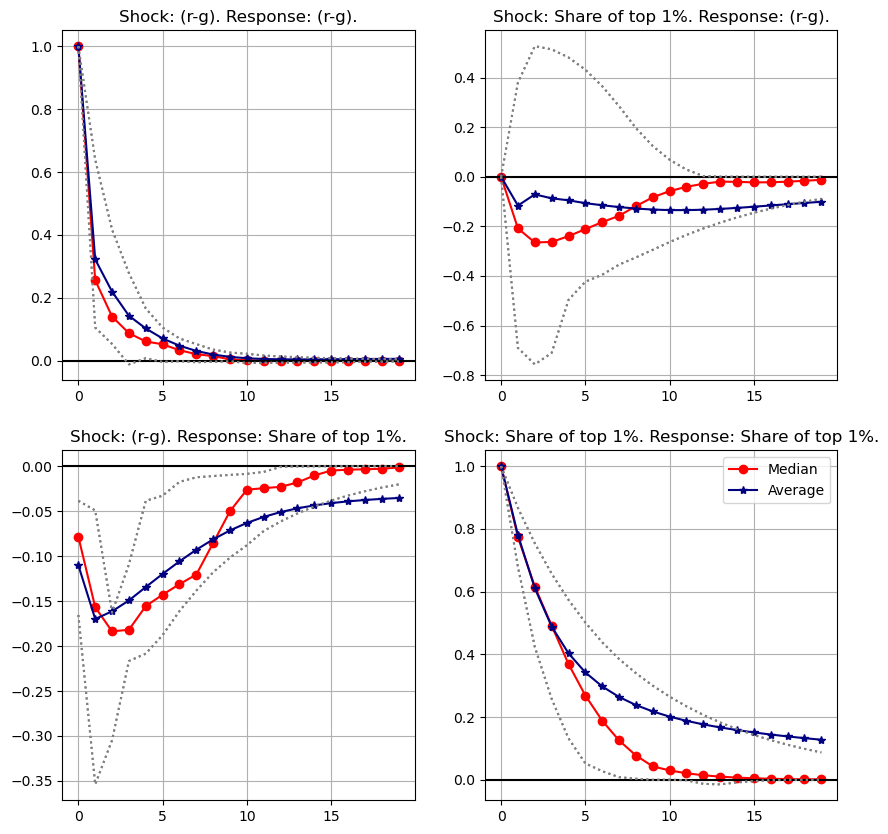

In [3]:
# Label figures
labels = {'rg1': '(r-g)',
          'top1': 'Share of top 1%'
          }

# Calculate moments of the distribution
moments_mat, median_mat, average_mat, pctiles = panel_var.collect_moments(irfs)
fig_moments = panel_var.plot_moments(variables, moments_mat, median_mat, average_mat, pctiles, titles_dict=labels)

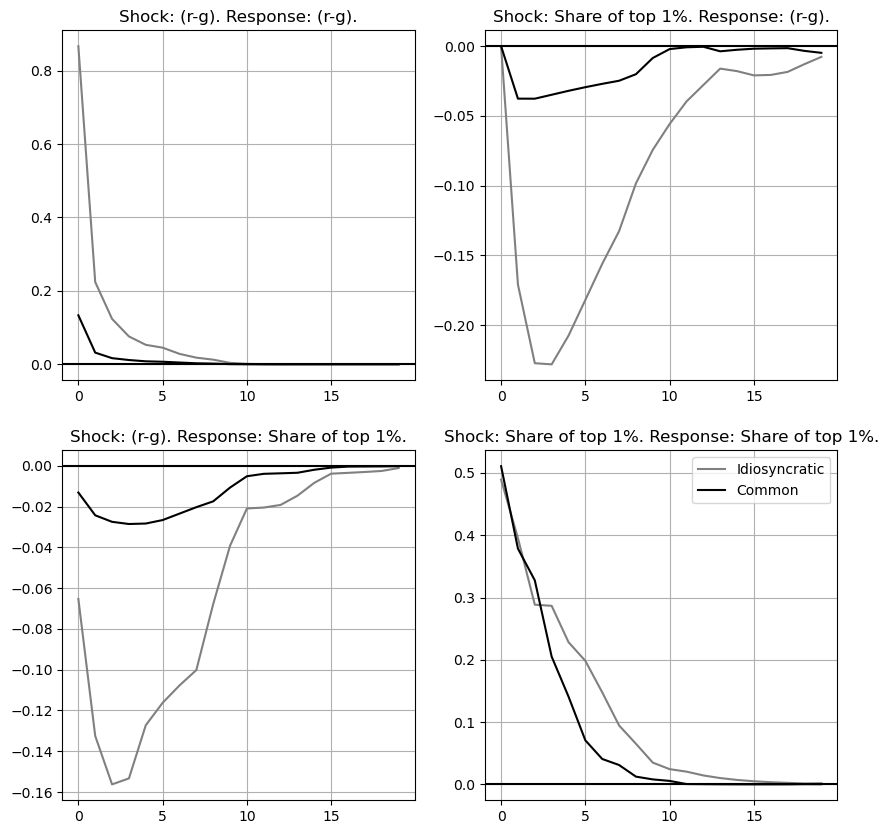

In [4]:
# Plot decomposed median IRFs:
median_common, median_id = panel_var.decompose_irfs(variables, lags=1)
fig_decomp = panel_var.plot_decomposed_irfs(median_common, median_id, titles_dict=labels)

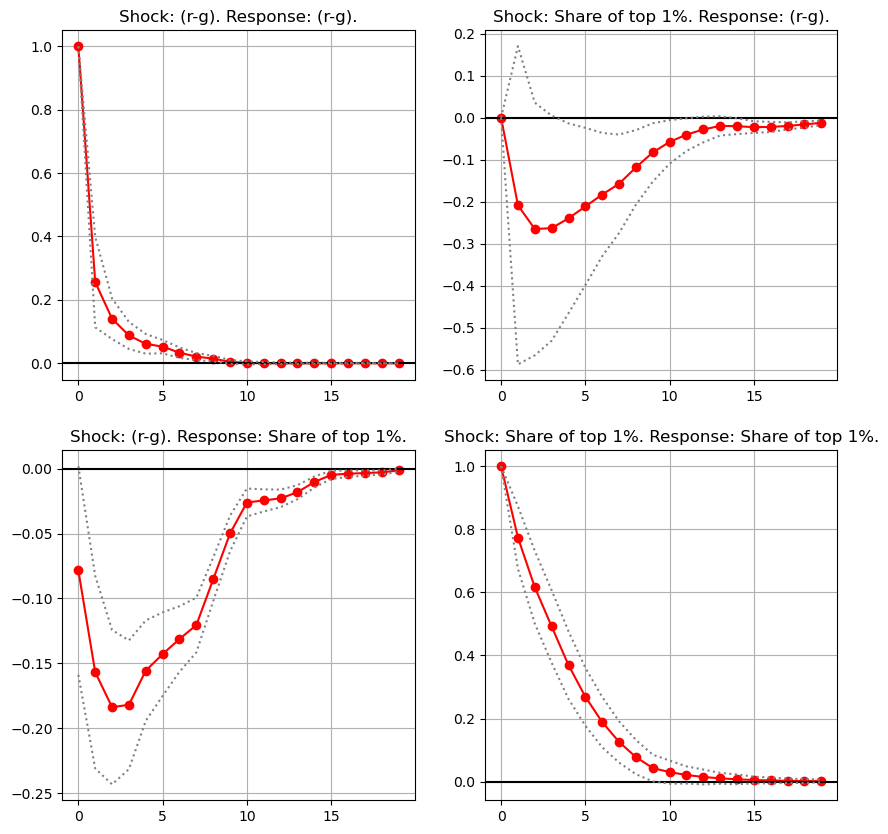

In [5]:
# Calculate and Plot Standard Erros of Medians
median_mat_se, average_mat_se = panel_var.calculate_se(variables, lags=1)
fig_se = panel_var.plot_se(median_mat, median_mat_se, variables, titles_dict=labels)